In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional, RepeatVector, TimeDistributed, ConvLSTM2D
from sklearn.preprocessing import MinMaxScaler
import time

In [2]:
df = pd.read_csv('../datasets/Plasma current.csv',usecols=[1]).clip(0)

In [3]:
df.head()

,Plasma_current
0,0.0000
1,1.3591
2,5.7585
3,11.6940
4,17.8730


In [4]:
df.size

401000

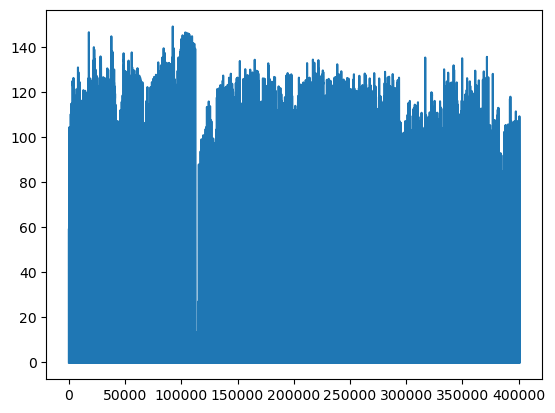

In [5]:
plt.plot(df)

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1)) #Also try QuantileTransformer
dataset = scaler.fit_transform(df)

In [7]:
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
test.shape

(80200, 1)

In [8]:
def to_sequences(dataset, time_window,output):
    x = []
    y = []

    for i in range(len(dataset)-time_window-1-output):
        #print(i)
        window = dataset[i:(i+time_window), 0]
        x.append(window)
        y.append(dataset[i+time_window:i+time_window+output, 0])

    return np.array(x),np.array(y)

In [9]:
time_window = 10
output=20 # Number of time steps to look back
#Larger sequences (look further back) may improve forecasting.

trainX, trainY = to_sequences(train, time_window, output)
testX, testY = to_sequences(test, time_window,output)

In [10]:
trainY.shape

(320769, 20)

In [11]:
trainX = trainX.reshape((trainX.shape[0], trainX.shape[1], 1))
print(trainX.shape)
testX = testX.reshape((testX.shape[0], testX.shape[1], 1))
print(testX.shape)
trainY = trainY.reshape((trainY.shape[0], trainY.shape[1], 1))
print(trainY.shape)
testY= testY.reshape((testY.shape[0], testY.shape[1], 1))
print(testY.shape)

(320769, 10, 1)
(80169, 10, 1)
(320769, 20, 1)
(80169, 20, 1)


In [12]:
import tensorflow as tf
import keras
from tensorflow.keras.layers import Dense, Input, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.models import Model

In [13]:
model = Sequential()

input_layer = Input(shape=(10,1))
x = Bidirectional(LSTM(50, activation='elu'))(input_layer)
x = RepeatVector(output)(x)
x = LSTM(100, activation='elu', return_sequences=True)(x)
x = TimeDistributed(Dense(1,activation='elu'))(x)

model = Model(inputs=input_layer, outputs=x)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 10, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 100)                 │          20,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 20, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 20, 100)             │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 20, 1)               │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 101,301 (395.71 KB)

 Trainable params: 101,301 (395.71 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model.compile(loss='mse', optimizer='adam')

In [15]:
callback = [keras.callbacks.EarlyStopping(monitor='loss',patience=3)]

In [16]:
model.fit(trainX, trainY, epochs=20, batch_size=32,validation_data=(testX,testY))

Epoch 1/20
10025/10025 ━━━━━━━━━━━━━━━━━━━━ 102s 10ms/step - loss: 0.0095 - val_loss: 0.0056
Epoch 2/20
10025/10025 ━━━━━━━━━━━━━━━━━━━━ 89s 9ms/step - loss: 0.0068 - val_loss: 0.0056
Epoch 3/20
10025/10025 ━━━━━━━━━━━━━━━━━━━━ 89s 9ms/step - loss: 0.0066 - val_loss: 0.0055
Epoch 4/20
10025/10025 ━━━━━━━━━━━━━━━━━━━━ 83s 8ms/step - loss: 0.0066 - val_loss: 0.0061
Epoch 5/20
10025/10025 ━━━━━━━━━━━━━━━━━━━━ 89s 9ms/step - loss: 0.0064 - val_loss: 0.0054
Epoch 6/20
10025/10025 ━━━━━━━━━━━━━━━━━━━━ 96s 10ms/step - loss: 0.0064 - val_loss: 0.0057
Epoch 7/20
10025/10025 ━━━━━━━━━━━━━━━━━━━━ 87s 9ms/step - loss: 0.0064 - val_loss: 0.0061
Epoch 8/20
10025/10025 ━━━━━━━━━━━━━━━━━━━━ 100s 10ms/step - loss: 0.0063 - val_loss: 0.0054
Epoch 9/20
10025/10025 ━━━━━━━━━━━━━━━━━━━━ 107s 11ms/step - loss: 0.0063 - val_loss: 0.0055
Epoch 10/20
10025/10025 ━━━━━━━━━━━━━━━━━━━━ 95s 10ms/step - loss: 0.0063 - val_loss: 0.0055
Epoch 11/20
10025/10025 ━━━━━━━━━━━━━━━━━━━━ 99s 10ms/step - loss: 0.0063 - val_l

In [17]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

10025/10025 ━━━━━━━━━━━━━━━━━━━━ 45s 4ms/step
2506/2506 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step


In [18]:
trainPredict.shape

(320769, 20, 1)

In [19]:
trainY.shape

(320769, 20, 1)

In [20]:
trainPredict = trainPredict.reshape(trainPredict.shape[0],trainPredict.shape[1])
testPredict = testPredict.reshape(testPredict.shape[0],testPredict.shape[1])

In [21]:
trainY = trainY.reshape(trainY.shape[0],trainY.shape[1])
testY = testY.reshape(testY.shape[0],testY.shape[1])

In [22]:
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)
trainY = scaler.inverse_transform(trainY)
testY = scaler.inverse_transform(testY)

In [23]:
from sklearn.metrics import mean_squared_error as mse
import math

In [24]:
train_RMSE = math.sqrt(mse(trainPredict,trainY))
test_RMSE = math.sqrt(mse(testPredict,testY))

In [25]:
train_RMSE

11.611820896430116

In [26]:
test_RMSE

10.925635103498374

In [27]:
trainY[:2]

array([[35.73 , 40.792, 42.312, 46.647, 49.429, 52.68 , 56.724, 55.462,
        55.672, 54.54 , 52.421, 51.208, 50.691, 51.483, 52.988, 52.567,
        53.829, 55.543, 54.524, 56.077],
       [40.792, 42.312, 46.647, 49.429, 52.68 , 56.724, 55.462, 55.672,
        54.54 , 52.421, 51.208, 50.691, 51.483, 52.988, 52.567, 53.829,
        55.543, 54.524, 56.077, 57.71 ]])

In [28]:
trainPredict[:2]

array([[31.25944 , 32.871815, 35.48076 , 36.646706, 36.891846, 37.78368 ,
        38.878952, 40.035454, 41.26412 , 42.518246, 43.75932 , 44.965458,
        46.12205 , 47.221245, 48.25907 , 49.23151 , 50.13685 , 50.974613,
        51.744698, 52.447056],
       [37.236515, 39.91184 , 45.233727, 47.980637, 50.25922 , 52.075985,
        53.92166 , 55.816303, 57.76029 , 59.754597, 61.761047, 63.75335 ,
        65.716125, 67.63385 , 69.48864 , 71.25482 , 72.89429 , 74.35613 ,
        75.58309 , 76.52553 ]], dtype=float32)

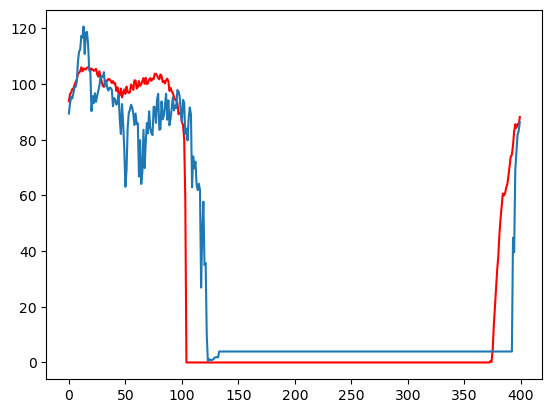

In [33]:
plt.plot(testY[400:800,19],color='r')
plt.plot(testPredict[400:800,19])

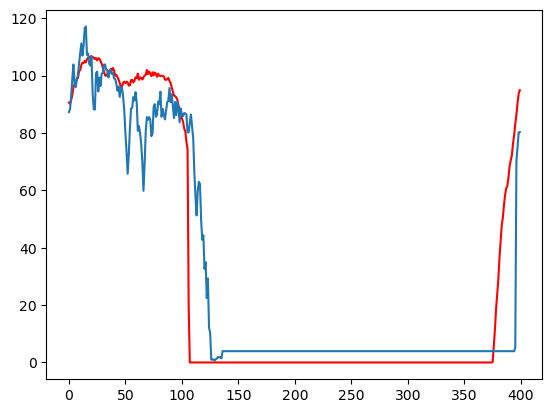

In [34]:
plt.plot(testY[800:1200,19],color='r')
plt.plot(testPredict[800:1200,19])